## 3D Segmentation Model on CT Abdomen Organs

Dataset: https://zenodo.org/records/7860267 (Used in Kaggle by uploading as a private dataset by name: ```ct-abdomen-organ-segmentation-dataset``` )

The CT images and pancreas annotations are from http://medicaldecathlon.com/

Credits to the following two papers:

A large annotated medical image dataset for the development and evaluation of segmentation algorithms

https://arxiv.org/abs/1902.09063

AbdomenCT-1K: Is Abdominal Organ Segmentation a Solved Problem?

https://ieeexplore.ieee.org/document/9497733

Classes and Labels

The dataset contains labels for various organs. Our focus is on the following organs:

- Liver
- Right Kidney
- Left Kidney
- Spleen

Refer to the image below for the specific classes corresponding to these organs.

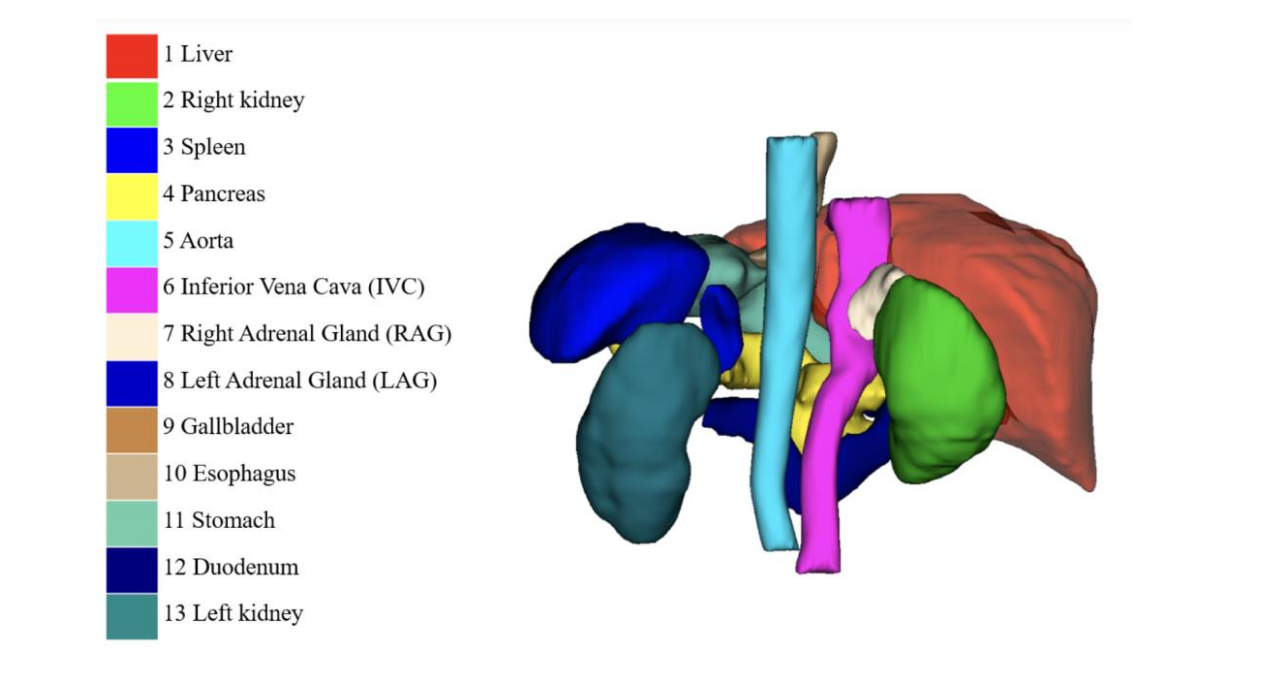

In [1]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from tqdm import tqdm
from skimage import measure
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib inline

## Sample

In [2]:
# Sample label file
sample_label_file = "/kaggle/input/ct-abdomen-organ-segmentation-dataset/FLARE22Train/labels/FLARE22_Tr_0001.nii/FLARE22_Tr_0001.nii"

label_img = nib.load(sample_label_file)
label_data = label_img.get_fdata()

unique_classes = np.unique(label_data)

print("Unique class IDs in the label file:")
print(unique_classes)

Unique class IDs in the label file:
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


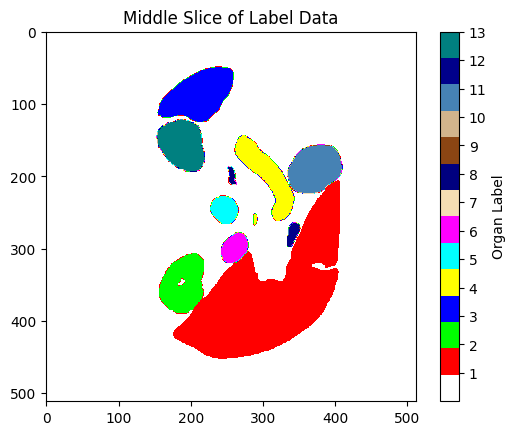

In [3]:
colors = [
    'white',     # 0 Background
    'red',       # 1 Liver
    'lime',      # 2 Right kidney
    'blue',      # 3 Spleen
    'yellow',    # 4 Pancreas
    'cyan',      # 5 Aorta
    'magenta',   # 6 Inferior Vena Cava (IVC)
    'wheat',     # 7 Right Adrenal Gland (RAG)
    'navy',      # 8 Left Adrenal Gland (LAG)
    'saddlebrown', # 9 Gallbladder
    'tan',       # 10 Esophagus
    'steelblue', # 11 Stomach
    'darkblue',  # 12 Duodenum
    'teal'       # 13 Left kidney
]

# Create a ListedColormap
cmap = ListedColormap(colors)

# Middle slice
slice_idx = label_data.shape[2] // 2
plt.imshow(label_data[:, :, slice_idx], cmap=cmap)
plt.title('Middle Slice of Label Data')
plt.colorbar(ticks=range(1, 14), label='Organ Label')
plt.show()

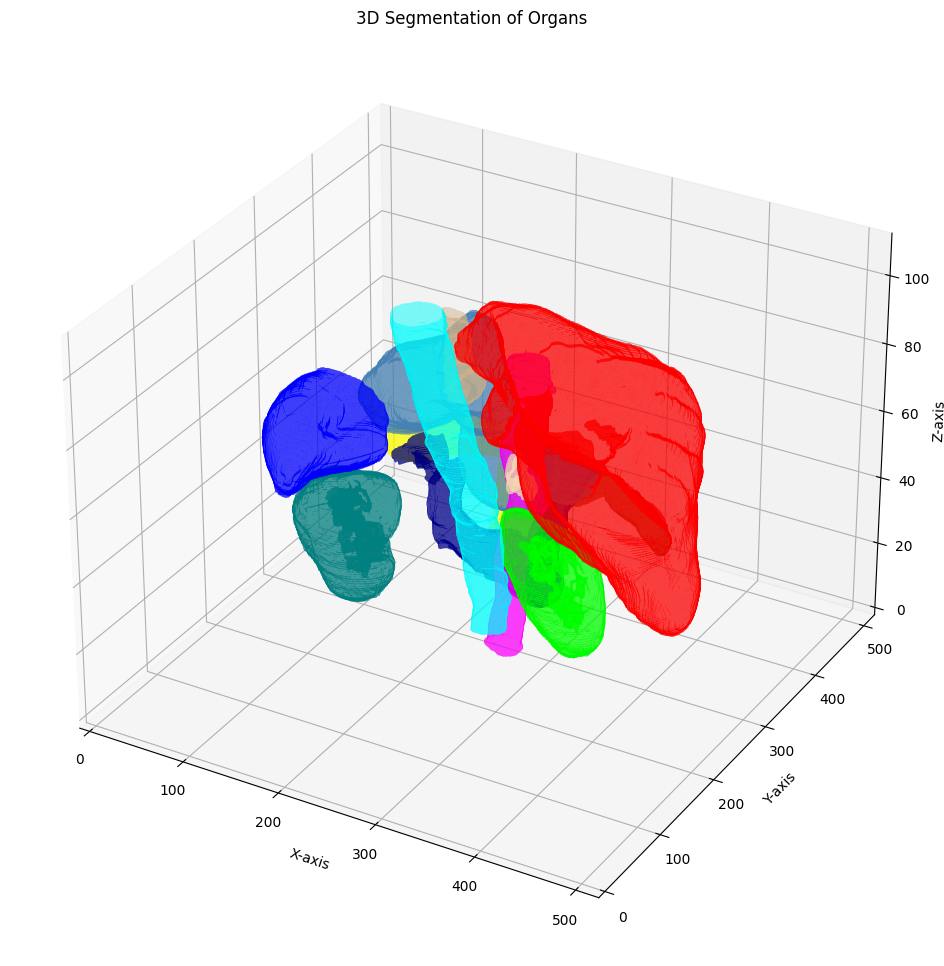

In [4]:
def visualize_3d_all_segmentations(volume, seg, organ_names, colors):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    num_classes = len(organ_names)
    
    cmap = ListedColormap(colors)
    
    for class_id in range(1, num_classes + 1):
        organ_name = organ_names[class_id - 1]
        
        verts, faces, _, _ = measure.marching_cubes(seg == class_id, level=0.5)
        
        mesh = Poly3DCollection(verts[faces], alpha=0.6, lw=1)
        mesh.set_facecolor(colors[class_id])
        ax.add_collection3d(mesh)
    
    ax.set_title('3D Segmentation of Organs')

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    
    ax.set_xlim(0, seg.shape[0])
    ax.set_ylim(0, seg.shape[1])
    ax.set_zlim(0, seg.shape[2])
    
    plt.show()

# List of organ names
organ_names = ["Liver", "Right Kidney", "Spleen", "Pancreas", "Aorta", "IVC", "RAG", "LAG", "Gallbladder", "Esophagus", "Stomach", "Duodenum", "Left Kidney"]

visualize_3d_all_segmentations(label_data, label_data, organ_names, colors)


## Data Processing

In [5]:
# (1: Liver, 2: Right Kidney, 3: Spleen, 13: Left Kidney)
target_classes = [1, 2, 3, 13]

# Data Preparation
class MedicalImageDataset(Dataset):
    def __init__(self, image_files, label_files, target_size=(128, 128, 64)):
        self.image_files = image_files
        self.label_files = label_files
        self.target_size = target_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img = nib.load(self.image_files[idx]).get_fdata()
        lbl = nib.load(self.label_files[idx]).get_fdata()

        # Resizing images and labels
        img_resized = zoom(img, (self.target_size[0] / img.shape[0], self.target_size[1] / img.shape[1], self.target_size[2] / img.shape[2]), order=1)
        lbl_resized = zoom(lbl, (self.target_size[0] / lbl.shape[0], self.target_size[1] / lbl.shape[1], self.target_size[2] / lbl.shape[2]), order=0)

        # Convert labels to integers
        lbl_resized = lbl_resized.astype(np.int32)
        
        # Filtering the labels for target organs
        lbl_filtered = np.zeros_like(lbl_resized, dtype=np.uint8)
        for j, target_class in enumerate(target_classes, start=1):
            lbl_filtered[lbl_resized == target_class] = j

        # Conversion to tensors
        img_tensor = torch.tensor(img_resized, dtype=torch.float32).unsqueeze(0)
        lbl_tensor = torch.tensor(lbl_filtered, dtype=torch.long)

        return img_tensor, lbl_tensor

# Load image and label files
imagesDir = "/kaggle/input/ct-abdomen-organ-segmentation-dataset/FLARE22Train/images"
labelsDir = "/kaggle/input/ct-abdomen-organ-segmentation-dataset/FLARE22Train/labels"

image_files = sorted([os.path.join(imagesDir, f) for f in os.listdir(imagesDir) if f.endswith(".nii")])
label_files = []

for dirpath, _, filenames in os.walk(labelsDir):
    for file in filenames:
        original_path = os.path.join(dirpath)
        label_file = os.path.join(original_path, file)
        label_files.append(label_file)
label_files = sorted(label_files)

# Split the dataset into training and validation sets
dataset = MedicalImageDataset(image_files, label_files)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

## VNet Model

In [6]:
# Model Definition
class VNet(nn.Module):
    def __init__(self):
        super(VNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(64, 128, 3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True),
            nn.ConvTranspose3d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True),
            nn.ConvTranspose3d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True),
        )
        self.final_conv = nn.Conv3d(16, 5, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.final_conv(x)
        return x

model = VNet()

## Training and Evaluation

In [7]:
# Training and Evaluation
def dice_coefficient(y_true, y_pred, n_classes=5):
    smooth = 1e-6
    dice_scores = {class_id: 0.0 for class_id in range(1, n_classes)}
    for i in range(1, n_classes):  # Skip background class 0
        intersection = ((y_true == i) & (y_pred == i)).sum()
        union = ((y_true == i) | (y_pred == i)).sum()
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores[i] = dice.item()
    return dice_scores

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 15
history = {'train_loss': [], 'val_loss': [], 'val_dice': {class_id: [] for class_id in range(1, 5)}}

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for imgs, lbls in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    history['train_loss'].append(avg_train_loss)
    print(f'Average Training Loss: {avg_train_loss:.4f}')

    model.eval()
    val_loss = 0.0
    dice_scores = {class_id: [] for class_id in range(1, 5)}
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            val_loss += loss.item() * imgs.size(0)

            pred = outputs.argmax(dim=1)
            batch_dice_scores = dice_coefficient(lbls.cpu().numpy(), pred.cpu().numpy())
            for class_id in range(1, 5):
                dice_scores[class_id].append(batch_dice_scores[class_id])

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_dice_scores = {class_id: np.mean(dice_scores[class_id]) for class_id in range(1, 5)}
    history['val_loss'].append(avg_val_loss)
    for class_id in range(1, 5):
        history['val_dice'][class_id].append(avg_dice_scores[class_id])

    print(f'Average Validation Loss: {avg_val_loss:.4f}')
    for class_id, dice_score in avg_dice_scores.items():
        organ_name = ["Liver", "Right Kidney", "Spleen", "Left Kidney"][class_id - 1]
        print(f'Average Dice Coefficient for {organ_name}: {dice_score:.4f}')

Epoch 1/15: 100%|██████████| 40/40 [01:13<00:00,  1.84s/it]


Average Training Loss: 0.2212
Average Validation Loss: 0.1182
Average Dice Coefficient for Liver: 0.6602
Average Dice Coefficient for Right Kidney: 0.0000
Average Dice Coefficient for Spleen: 0.0000
Average Dice Coefficient for Left Kidney: 0.0000


Epoch 2/15: 100%|██████████| 40/40 [00:19<00:00,  2.00it/s]


Average Training Loss: 0.1013
Average Validation Loss: 0.0857
Average Dice Coefficient for Liver: 1.2255
Average Dice Coefficient for Right Kidney: 0.5759
Average Dice Coefficient for Spleen: 0.0000
Average Dice Coefficient for Left Kidney: 0.0725


Epoch 3/15: 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]


Average Training Loss: 0.0818
Average Validation Loss: 0.0818
Average Dice Coefficient for Liver: 1.2019
Average Dice Coefficient for Right Kidney: 0.6731
Average Dice Coefficient for Spleen: 0.0000
Average Dice Coefficient for Left Kidney: 0.5559


Epoch 4/15: 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]


Average Training Loss: 0.0748
Average Validation Loss: 0.0697
Average Dice Coefficient for Liver: 1.3331
Average Dice Coefficient for Right Kidney: 0.7208
Average Dice Coefficient for Spleen: 0.0725
Average Dice Coefficient for Left Kidney: 0.3177


Epoch 5/15: 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]


Average Training Loss: 0.0652
Average Validation Loss: 0.0835
Average Dice Coefficient for Liver: 1.0004
Average Dice Coefficient for Right Kidney: 0.4324
Average Dice Coefficient for Spleen: 0.0816
Average Dice Coefficient for Left Kidney: 0.4778


Epoch 6/15: 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]


Average Training Loss: 0.0604
Average Validation Loss: 0.0606
Average Dice Coefficient for Liver: 1.3869
Average Dice Coefficient for Right Kidney: 0.7112
Average Dice Coefficient for Spleen: 0.3623
Average Dice Coefficient for Left Kidney: 0.4360


Epoch 7/15: 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]


Average Training Loss: 0.0567
Average Validation Loss: 0.0585
Average Dice Coefficient for Liver: 1.4020
Average Dice Coefficient for Right Kidney: 0.8377
Average Dice Coefficient for Spleen: 0.7855
Average Dice Coefficient for Left Kidney: 0.7659


Epoch 8/15: 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]


Average Training Loss: 0.0529
Average Validation Loss: 0.0569
Average Dice Coefficient for Liver: 1.4285
Average Dice Coefficient for Right Kidney: 0.8561
Average Dice Coefficient for Spleen: 0.8595
Average Dice Coefficient for Left Kidney: 0.8626


Epoch 9/15: 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]


Average Training Loss: 0.0495
Average Validation Loss: 0.0627
Average Dice Coefficient for Liver: 1.2595
Average Dice Coefficient for Right Kidney: 0.8759
Average Dice Coefficient for Spleen: 0.5902
Average Dice Coefficient for Left Kidney: 0.8389


Epoch 10/15: 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]


Average Training Loss: 0.0466
Average Validation Loss: 0.0503
Average Dice Coefficient for Liver: 1.4617
Average Dice Coefficient for Right Kidney: 0.9071
Average Dice Coefficient for Spleen: 0.8895
Average Dice Coefficient for Left Kidney: 0.8454


Epoch 11/15: 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]


Average Training Loss: 0.0426
Average Validation Loss: 0.0519
Average Dice Coefficient for Liver: 1.4647
Average Dice Coefficient for Right Kidney: 0.9337
Average Dice Coefficient for Spleen: 0.9273
Average Dice Coefficient for Left Kidney: 0.7912


Epoch 12/15: 100%|██████████| 40/40 [00:19<00:00,  2.01it/s]


Average Training Loss: 0.0417
Average Validation Loss: 0.0530
Average Dice Coefficient for Liver: 1.4457
Average Dice Coefficient for Right Kidney: 1.0028
Average Dice Coefficient for Spleen: 0.9793
Average Dice Coefficient for Left Kidney: 0.9286


Epoch 13/15: 100%|██████████| 40/40 [00:19<00:00,  2.01it/s]


Average Training Loss: 0.0420
Average Validation Loss: 0.0494
Average Dice Coefficient for Liver: 1.4736
Average Dice Coefficient for Right Kidney: 0.8879
Average Dice Coefficient for Spleen: 1.0096
Average Dice Coefficient for Left Kidney: 0.9076


Epoch 14/15: 100%|██████████| 40/40 [00:19<00:00,  2.01it/s]


Average Training Loss: 0.0382
Average Validation Loss: 0.0464
Average Dice Coefficient for Liver: 1.4772
Average Dice Coefficient for Right Kidney: 0.9491
Average Dice Coefficient for Spleen: 0.9807
Average Dice Coefficient for Left Kidney: 1.0099


Epoch 15/15: 100%|██████████| 40/40 [00:19<00:00,  2.03it/s]


Average Training Loss: 0.0380
Average Validation Loss: 0.0462
Average Dice Coefficient for Liver: 1.4733
Average Dice Coefficient for Right Kidney: 1.0014
Average Dice Coefficient for Spleen: 1.0674
Average Dice Coefficient for Left Kidney: 1.0082


## Plotting

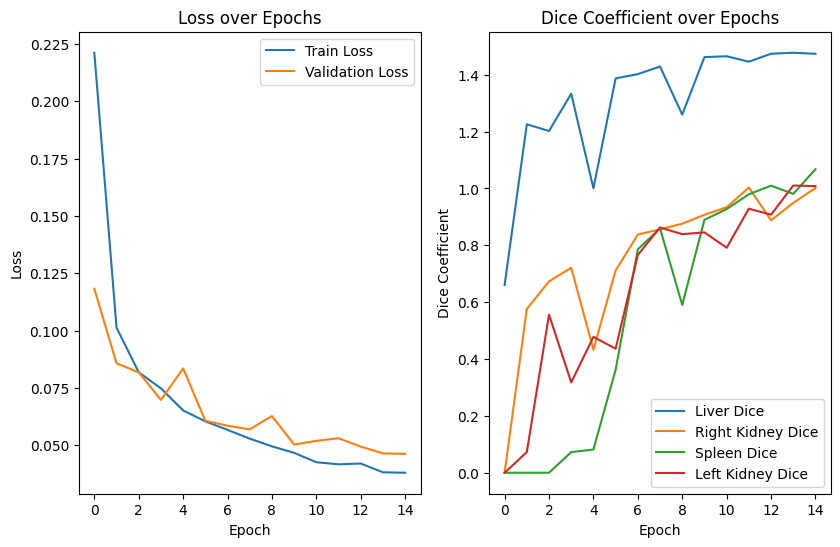

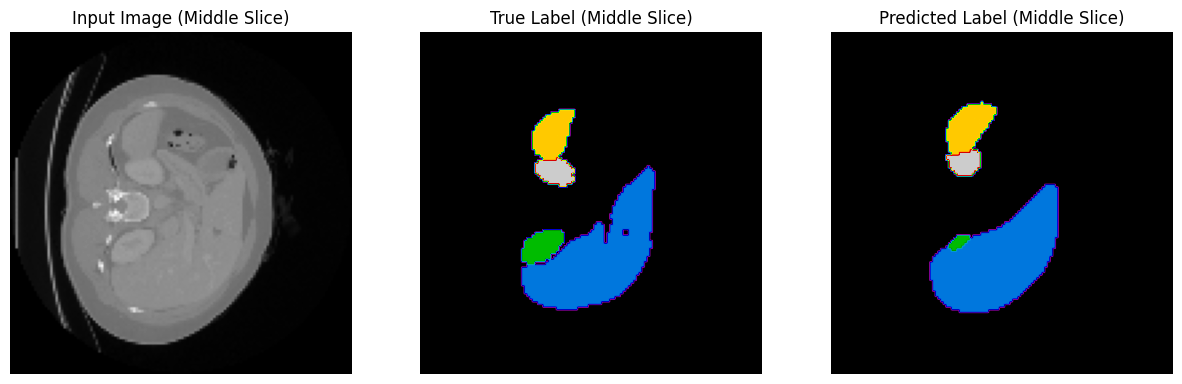

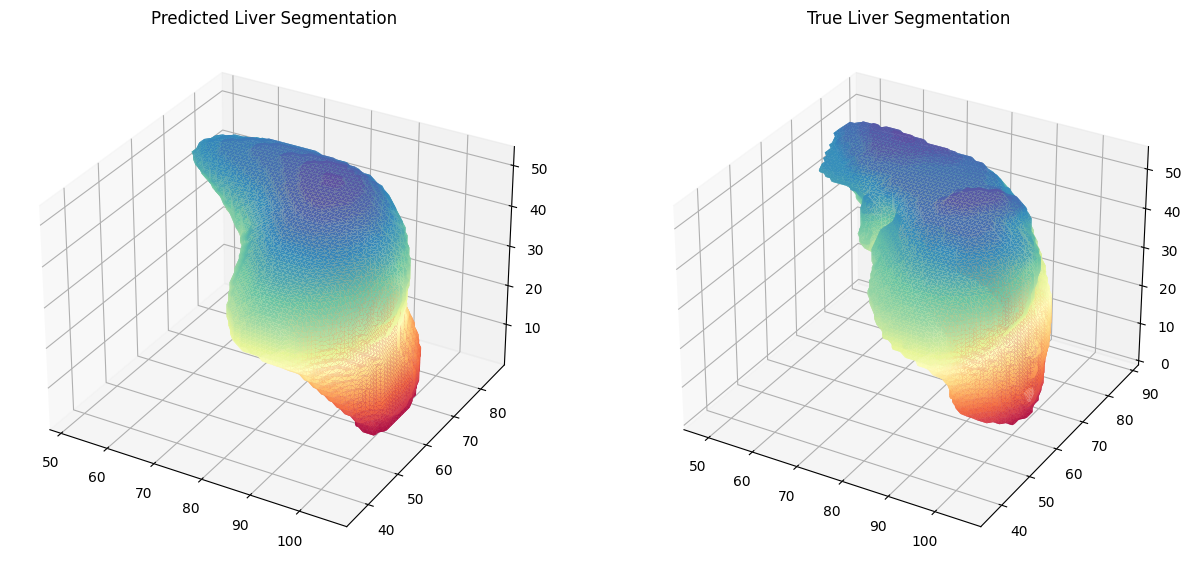

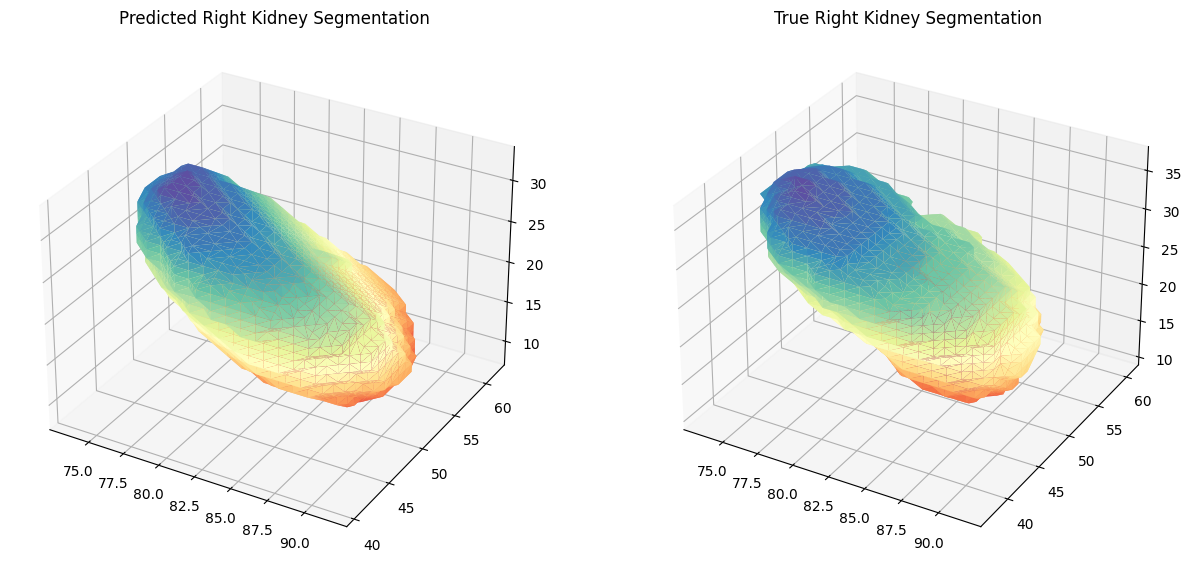

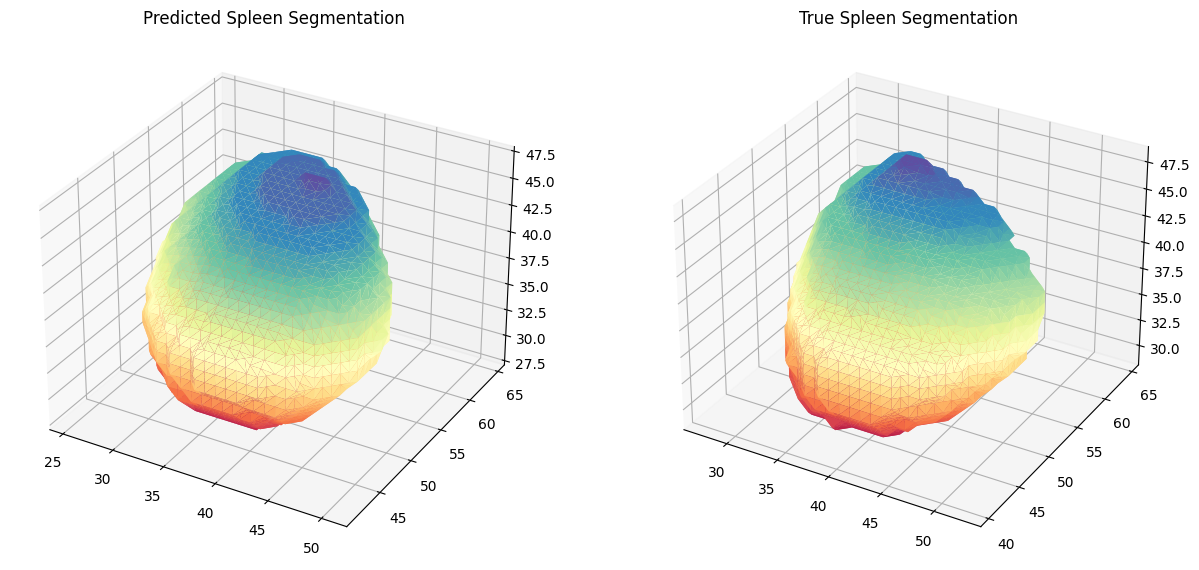

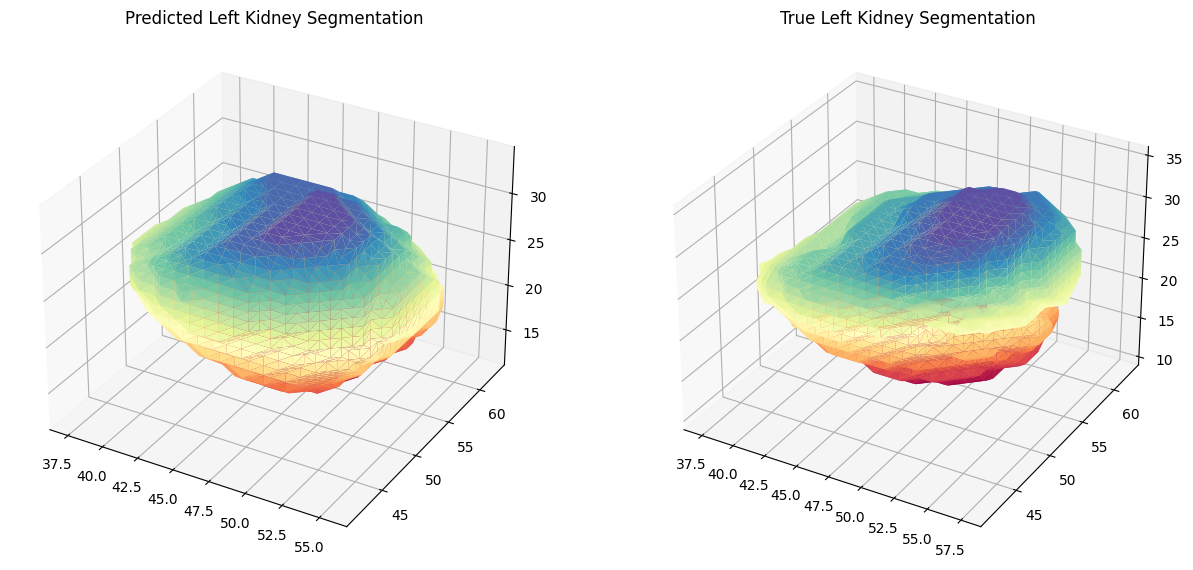

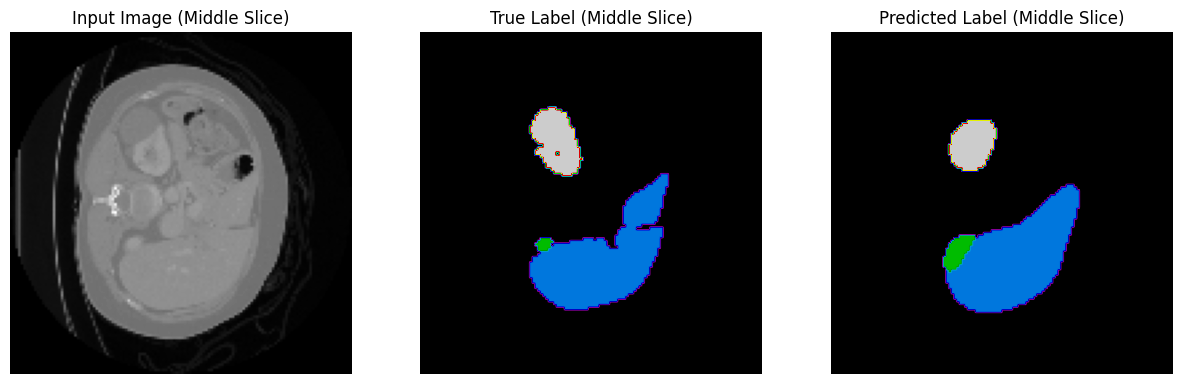

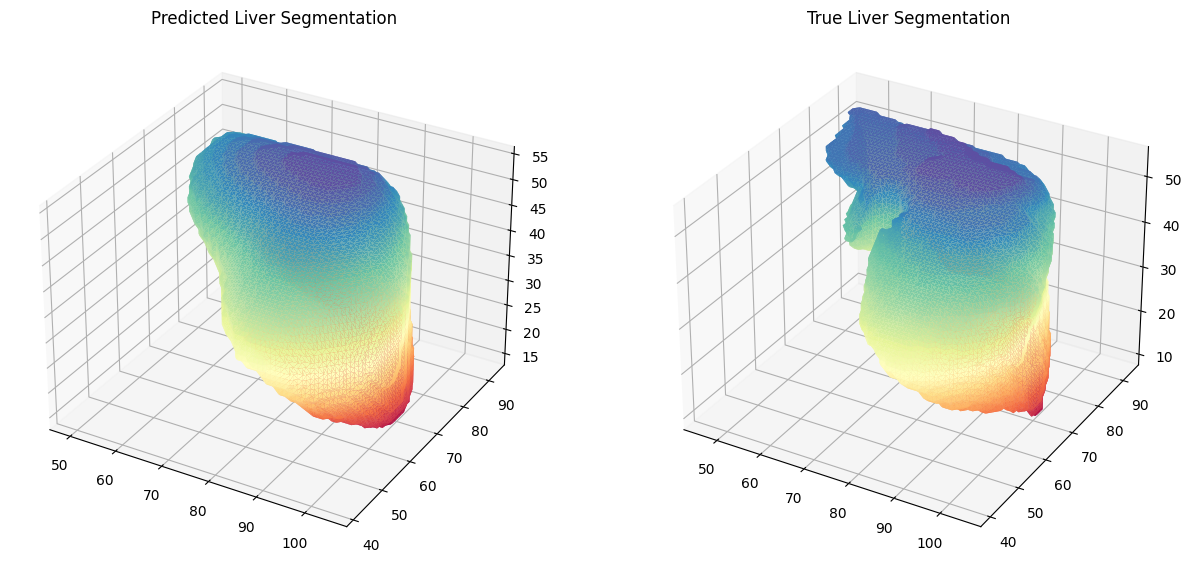

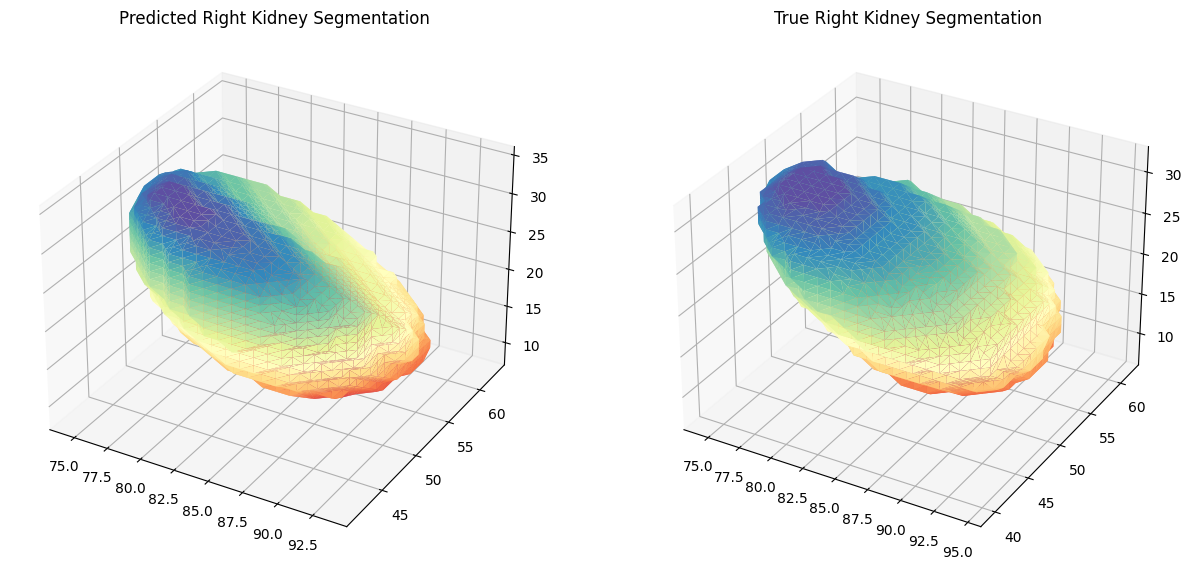

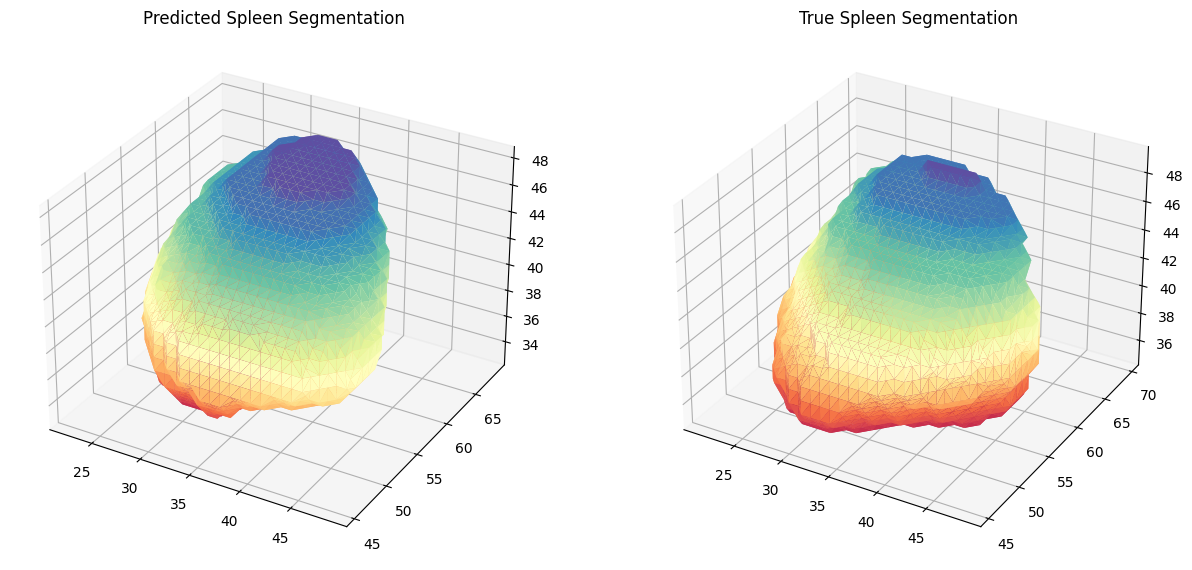

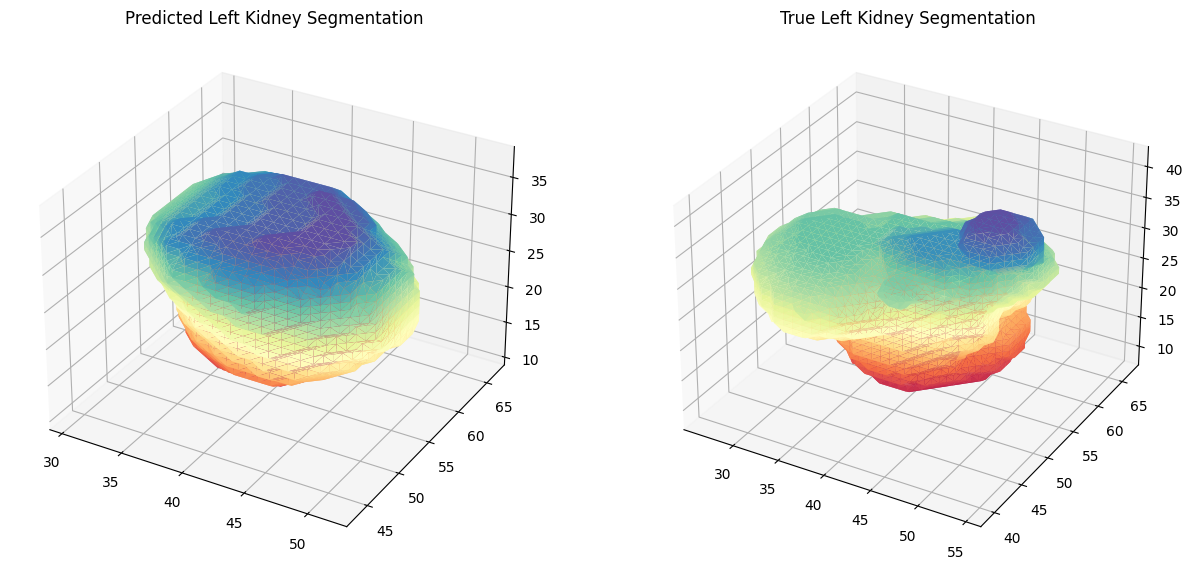

In [8]:
# Plot training history
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
for class_id in range(1, 5):
    organ_name = ["Liver", "Right Kidney", "Spleen", "Left Kidney"][class_id - 1]
    plt.plot(history['val_dice'][class_id], label=f'{organ_name} Dice')
plt.title('Dice Coefficient over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.show()

# 3D Visualization Function
def visualize_3d_prediction(img, pred, label, organ_name, class_id):
    verts_pred, faces_pred, _, _ = measure.marching_cubes(pred == class_id, 0.5)
    verts_lbl, faces_lbl, _, _ = measure.marching_cubes(label == class_id, 0.5)

    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_trisurf(verts_pred[:, 0], verts_pred[:, 1], faces_pred, verts_pred[:, 2],
                     cmap='Spectral', lw=1)
    ax1.set_title(f'Predicted {organ_name} Segmentation')

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_trisurf(verts_lbl[:, 0], verts_lbl[:, 1], faces_lbl, verts_lbl[:, 2],
                     cmap='Spectral', lw=1)
    ax2.set_title(f'True {organ_name} Segmentation')

    plt.show()

# Visualize predictions for a few samples
def visualize_predictions(loader, model, num_samples=3):
    model.eval()
    with torch.no_grad():
        for i, (imgs, lbls) in enumerate(loader):
            if i >= num_samples:
                break
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            pred = outputs.argmax(dim=1).cpu().numpy()
            lbls = lbls.cpu().numpy()
            
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            middle_slice = imgs[0, 0, :, :, imgs.shape[4] // 2].cpu().numpy()
            axes[0].imshow(middle_slice, cmap='gray')
            axes[0].set_title('Input Image (Middle Slice)')
            axes[0].axis('off')

            true_slice = lbls[0, :, :, imgs.shape[4] // 2]
            pred_slice = pred[0, :, :, imgs.shape[4] // 2]
            axes[1].imshow(true_slice, cmap='nipy_spectral', vmin=0, vmax=4)
            axes[1].set_title('True Label (Middle Slice)')
            axes[1].axis('off')

            axes[2].imshow(pred_slice, cmap='nipy_spectral', vmin=0, vmax=4)
            axes[2].set_title('Predicted Label (Middle Slice)')
            axes[2].axis('off')

            plt.show()

            for class_id in range(1, 5):
                organ_name = ["Liver", "Right Kidney", "Spleen", "Left Kidney"][class_id - 1]
                visualize_3d_prediction(imgs[0, 0].cpu().numpy(), pred[0], lbls[0], organ_name, class_id)

visualize_predictions(val_loader, model, num_samples=2)

## Saving

In [9]:
# Save the model
model_save_path = "/kaggle/working/3D_Segmentation_Model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/3D_Segmentation_Model.pth


### Future Improvements

1. Any unnoticed bugs.

2. Would work on optimizing the model so that better dice coefficients are produced for organs, eventually leading to better results.